In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
from scipy import io

from sklearn.metrics import mean_squared_error

In [2]:
import warnings
from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.linalg import pinv2, svd
from scipy.sparse.linalg import svds

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils import check_array, check_consistent_length
from sklearn.utils.extmath import svd_flip
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.externals import six


def f(x, kind='linear', params=None):
    if kind == 'linear':
        return x
    elif kind == 'g1':
        return np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.abs(x)) - 1)
    elif kind == 'g2':
        return np.sign(x) * np.exp(params[0]) * np.sqrt(np.abs(x))
    elif kind == 'g3':
        return np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.sqrt(np.abs(x))) - 1)
    elif kind == 'g4':
        return np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.abs(x) ** (1./3)) - 1)


def finv(y, kind='linear', params=None, eps=1e-9):
    if kind == 'linear':
        return y
    elif kind == 'g1':
        return np.sign(y) * np.log(1 + np.abs(y) * np.exp(-params[0])) / (params[1] + eps)
    elif kind == 'g2':
        return np.sign(y) * (np.exp(-params[0]) * y) ** 2
    elif kind == 'g3':
        return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-params[0])) / (params[1] + eps)) ** 2
    elif kind == 'g4':
        return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-params[0])) / (params[1] + eps)) ** 3


def fgrad(x, kind='linear', params=None, eps=1e-9):
    if kind == 'linear':
        return None
    elif kind == 'g1':
        grad = np.stack([np.zeros_like(x), np.zeros_like(x)], axis=2)
        grad[:, :, 0] = np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.abs(x)) - 1)
        grad[:, :, 1] = x * np.exp(params[0]) * (np.exp(params[1] * np.abs(x)) - 1)
    elif kind == 'g2:
        grad = np.zeros_like(x)[:, :, np.newaxis]
        grad = np.sign(x) * np.exp(params[0]) np.sqrt(np.abs(x))
    elif kind == 'g3':
        grad = np.stack([np.zeros_like(x), np.zeros_like(x)], axis=2)
        grad[:, :, 0] = np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.sqrt(np.abs(x))) - 1)
        grad[:, :, 1] = np.exp(params[0]) * (np.exp(params[1] * 
                                                    np.sqrt(np.abs(x))) - 1) / (2. * np.sqrt(np.abs(x)) + eps)
    elif kind == 'g4':
        grad = np.stack([np.zeros_like(x), np.zeros_like(x)], axis=2)
        grad[:, :, 0] = np.sign(x) * np.exp(params[0]) * (np.exp(params[1] * np.abs(x) ** (1./3)) - 1)
        grad[:, :, 1] = np.exp(params[0]) * (np.exp(params[1] * 
                                                    np.abs(x) ** (1./3)) - 1)  / (3. * (np.abs(x)) ** (2./3) + eps)


def jacob():
    if kind == 'linear':
        return None
    elif kind == 'g1':
        
    elif kind == 'g2:
        pass
    elif kind == 'g3':
        pass
    elif kind == 'g4':
        pass


def params_initialize(kind='linear'):
    if kind == 'linear':
        return None
    elif kind == 'exp':
        pass
    elif kind == 'softplus':
        pass
    elif kind == 'sigmoid':
        pass
    elif kind == 'relu':
        pass
    elif kind == 'leaky_relu':
        pass
    elif kind == 'elu':
        pass


def _center_scale_xy(X, Y, scale=True):
    """ Center X, Y and scale if the scale parameter==True

    Returns
    -------
        X, Y, x_mean, y_mean, x_std, y_std
    """
    # center
    x_mean = X.mean(axis=0)
    X -= x_mean
    y_mean = Y.mean(axis=0)
    Y -= y_mean
    # scale
    if scale:
        x_std = X.std(axis=0, ddof=1)
        x_std[x_std == 0.0] = 1.0
        X /= x_std
        y_std = Y.std(axis=0, ddof=1)
        y_std[y_std == 0.0] = 1.0
        Y /= y_std
    else:
        x_std = np.ones(X.shape[1])
        y_std = np.ones(Y.shape[1])
    return X, Y, x_mean, y_mean, x_std, y_std


def _nipals_twoblocks_inner_loop(X, Y, x_kind='linear', y_kind='linear', 
                                 x_params=None, y_params=None, max_iter=500, tol=1e-06):
    """Inner loop of the iterative NIPALS algorithm.

    Provides an alternative to the svd(X'Y); returns the first left and right
    singular vectors of X'Y.  See PLS for the meaning of the parameters.  It is
    similar to the Power method for determining the eigenvectors and
    eigenvalues of a X'Y.
    """
# STEP 4
    x_score = X[:, [0]]
# STEP 5
    y_score = Y[:, [0]]
    x_weights_old = 0
    ite = 1
    X_pinv = Y_pinv = None
    eps = np.finfo(X.dtype).eps
    # Inner loop of the Wold algo.
# STEP 6
    while True:
# STEP 7        
        y_score_old = y_score.copy()
        x_score_old = x_score.copy()
# STEP 8        
        X_hat = f(X, kind=x_kind, params=x_params)
        Y_hat = f(Y, kind=y_kind, params=y_params)
        # 1.1 Update u: the X weights
        # Mode A regress each X column on y_score
# STEP 9
        x_weights = np.dot(X_hat.T, y_score) / np.dot(y_score.T, y_score)
        # If y_score only has zeros x_weights will only have zeros. In
        # this case add an epsilon to converge to a more acceptable
        # solution
        if np.dot(x_weights.T, x_weights) < eps:
            x_weights += eps
        # 1.2 Normalize u
        x_weights /= np.sqrt(np.dot(x_weights.T, x_weights)) + eps
        # 1.3 Update x_score: the X latent scores
# STEP 10
        x_score = np.dot(X_hat, x_weights)
# STEP 11
        if x_kind != 'linear':
            J_t = jacob(a, kind=kind, params=x_params)
            delta_x_params = np.linalg.inv(J_t.T.dot(J_t)).dot(J_t.T).dot(x_score - x_score_old)
# STEP 12
            x_params += delta_x_params
        # 2.1 Update y_weights
        # Mode A regress each Y column on x_score
# STEP 13
        y_weights = np.dot(Y_hat.T, x_score) / np.dot(x_score.T, x_score)
        y_weights /= np.sqrt(np.dot(y_weights.T, y_weights)) + eps
        # 2.2 Update y_score: the Y latent scores
# STEP 14
        y_score = np.dot(Y_hat, y_weights)
# STEP 15
        if y_kind != 'linear':
            J_u = jacob(a, kind=kind, params=y_params)
            delta_y_params = np.linalg.inv(J_u.T.dot(J_u)).dot(J_u.T).dot(y_score - y_score_old)
# STEP 16
            y_params += delta_y_params
        x_weights_diff = x_weights - x_weights_old
        if np.dot(x_weights_diff.T, x_weights_diff) < tol or Y.shape[1] == 1:
            break
        if ite == max_iter:
            warnings.warn('Maximum number of iterations reached')
            break
        x_weights_old = x_weights
        ite += 1
    return x_weights, y_weights, ite


class _PLS(six.with_metaclass(ABCMeta), BaseEstimator, TransformerMixin,
           RegressorMixin):
    """Partial Least Squares (PLS)

    This class implements the generic PLS algorithm, constructors' parameters
    allow to obtain a specific implementation such as:

    - PLS2 regression, i.e., PLS 2 blocks, mode A, with asymmetric deflation
      and unnormalized y weights such as defined by [Tenenhaus 1998] p. 132.
      With univariate response it implements PLS1.

    - PLS canonical, i.e., PLS 2 blocks, mode A, with symmetric deflation and
      normalized y weights such as defined by [Tenenhaus 1998] (p. 132) and
      [Wegelin et al. 2000]. This parametrization implements the original Wold
      algorithm.

    We use the terminology defined by [Wegelin et al. 2000].
    This implementation uses the PLS Wold 2 blocks algorithm based on two
    nested loops:
        (i) The outer loop iterate over components.
        (ii) The inner loop estimates the weights vectors. This can be done
        with two algo. the inner loop of the original NIPALS algo.
        
    n_components : int, number of components to keep. (default 2).
    scale : boolean, scale data? (default True)
    max_iter : an integer, the maximum number of iterations (default 500)
        of the NIPALS inner loop (used only if algorithm="nipals")
    tol : non-negative real, default 1e-06
        The tolerance used in the iterative algorithm.
    copy : boolean, default True
        Whether the deflation should be done on a copy. Let the default
        value to True unless you don't care about side effects.

    Attributes
    ----------
    x_weights_ : array, [p, n_components] X block weights vectors.
    y_weights_ : array, [q, n_components] Y block weights vectors.
    x_loadings_ : array, [p, n_components] X block loadings vectors.
    y_loadings_ : array, [q, n_components] Y block loadings vectors.
    x_scores_ : array, [n_samples, n_components] X scores.
    y_scores_ : array, [n_samples, n_components] Y scores.
    x_rotations_ : array, [p, n_components] X block to latents rotations.
    y_rotations_ : array, [q, n_components] Y block to latents rotations.
    coef_ : array, [p, q] The coefficients of the linear model: ``Y = X coef_ + Err``
    n_iter_ : array-like Number of iterations of the NIPALS inner loop for each component.

    """

    @abstractmethod
    def __init__(self, n_components=2, scale=True,
                 x_kind="linear", y_kind='linear', max_iter=500, tol=1e-06):
        self.n_components = n_components
        self.scale = scale
        self.x_kind = x_kind
        self.y_kind = y_kind
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, Y):
        """Fit model to data.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.

        Y : array-like, shape = [n_samples, n_targets]
            Target vectors, where n_samples is the number of samples and
            n_targets is the number of response variables.
        """

        # copy since this will contains the residuals (deflated) matrices
        check_consistent_length(X, Y)
        X = check_array(X, dtype=np.float64, copy=True)
        Y = check_array(Y, dtype=np.float64, copy=True, ensure_2d=False)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)

        n = X.shape[0]
        p = X.shape[1]
        q = Y.shape[1]

        if self.n_components < 1 or self.n_components > p:
            raise ValueError('Invalid number of components: %d' %
                             self.n_components)
        # Scale (in place)
        X, Y, self.x_mean_, self.y_mean_, self.x_std_, self.y_std_ = (
            _center_scale_xy(X, Y, self.scale))
        # Residuals (deflated) matrices
        Xk = X.copy()
        Yk = Y.copy()
# STEP 1
        self.x_params = params_initialize(kind=self.x_kind)
        self.y_params = params_initialize(kind=self.y_kind)
        # Results matrices
# STEP 2
        self.x_scores_ = np.zeros((n, self.n_components))
        self.y_scores_ = np.zeros((n, self.n_components))
        self.x_weights_ = np.zeros((p, self.n_components))
        self.y_weights_ = np.zeros((q, self.n_components))
        self.x_loadings_ = np.zeros((p, self.n_components))
        self.y_loadings_ = np.zeros((q, self.n_components))
        self.n_iter_ = []

        # NIPALS algo: outer loop, over components
# STEP 3
        for k in range(self.n_components):
            if np.all(np.dot(Yk.T, Yk) < np.finfo(np.double).eps):
                # Yk constant
                warnings.warn('Y residual constant at iteration %s' % k)
                break
            # 1) weights estimation (inner loop)
            # -----------------------------------
# STEP 17
            x_weights, y_weights, n_iter_ = \
                _nipals_twoblocks_inner_loop(
                    X=Xk, Y=Yk, max_iter=self.max_iter,
                    tol=self.tol, x_kind=self.x_kind, y_kind=self.y_kind,
                    x_params=self.x_params, y_params=self.y_params)
            self.n_iter_.append(n_iter_)
            # Forces sign stability of x_weights and y_weights
            # Sign undeterminacy issue from svd if algorithm == "svd"
            # and from platform dependent computation if algorithm == 'nipals'
            x_weights, y_weights = svd_flip(x_weights, y_weights.T)
            y_weights = y_weights.T
            # compute scores
            
            Xk_hat = f(Xk, kind=self.x_kind, params=self.x_params)
            Yk_hat = f(Yk, kind=self.y_kind, params=self.y_params)
            
            x_scores = np.dot(Xk_hat, x_weights)
            y_ss = np.dot(y_weights.T, y_weights)
            y_scores = np.dot(Yk_hat, y_weights) / y_ss
            # test for null variance
            if np.dot(x_scores.T, x_scores) < np.finfo(np.double).eps:
                warnings.warn('X scores are null at iteration %s' % k)
                break
            # 2) Deflation (in place)
            # ----------------------
            # Possible memory footprint reduction may done here: in order to
            # avoid the allocation of a data chunk for the rank-one
            # approximations matrix which is then subtracted to Xk, we suggest
            # to perform a column-wise deflation.
            #
# STEP 19
            x_loadings = np.dot(Xk_hat.T, x_scores) / np.dot(x_scores.T, x_scores)
            y_loadings = (np.dot(Yk_hat.T, x_scores)
                          / np.dot(x_scores.T, x_scores))
            # - regress Xk's on x_score
            # - subtract rank-one approximations to obtain remainder matrix
# STEP 22
            Xk_hat -= np.dot(x_scores, x_loadings.T)
            # - regress Yk's on x_score, then subtract rank-one approx.
# STEP 23
            Yk_hat -= np.dot(x_scores, y_loadings.T)
# STEP 24
            Xk = finv(Xk_hat, kind=self.x_kind, params=self.x_params)
            Yk = finv(Yk_hat, kind=self.y_kind, params=self.y_params)
            # 3) Store weights, scores and loadings # Notation:
            self.x_scores_[:, k] = x_scores.ravel()  # T
            self.y_scores_[:, k] = y_scores.ravel()  # U
            self.x_weights_[:, k] = x_weights.ravel()  # W
            self.y_weights_[:, k] = y_weights.ravel()  # C
            self.x_loadings_[:, k] = x_loadings.ravel()  # P
            self.y_loadings_[:, k] = y_loadings.ravel()  # Q
        # Such that: X = TP' + Err and Y = UQ' + Err

        # 4) rotations from input space to transformed space (scores)
        # T = X W(P'W)^-1 = XW* (W* : p x k matrix)
        # U = Y C(Q'C)^-1 = YC* (C* : q x k matrix)
        self.x_rotations_ = np.dot(
            self.x_weights_,
            pinv2(np.dot(self.x_loadings_.T, self.x_weights_),
                  check_finite=False))
        if Y.shape[1] > 1:
            self.y_rotations_ = np.dot(
                self.y_weights_,
                pinv2(np.dot(self.y_loadings_.T, self.y_weights_),
                      check_finite=False))
        else:
            self.y_rotations_ = np.ones(1)

        # Estimate regression coefficient
        # Regress Y on T
        # Y = TQ' + Err,
        # Then express in function of X
        # Y = X W(P'W)^-1Q' + Err = XB + Err
        # => B = W*Q' (p x q)
        self.coef_ = np.dot(self.x_rotations_, self.y_loadings_.T)
        # self.coef_ = self.coef_ * self.y_std_
        return self

    def transform(self, X, Y=None):
        """Apply the dimension reduction learned on the train data.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.

        Y : array-like, shape = [n_samples, n_targets]
            Target vectors, where n_samples is the number of samples and
            n_targets is the number of response variables.

        copy : boolean, default True
            Whether to copy X and Y, or perform in-place normalization.

        Returns
        -------
        x_scores if Y is not given, (x_scores, y_scores) otherwise.
        """
        check_is_fitted(self, 'x_mean_')
        X = check_array(X, dtype=FLOAT_DTYPES, copy=True)
        # Normalize
        X -= self.x_mean_
        X /= self.x_std_
        # Apply rotation
        x_scores = np.dot(X, self.x_rotations_)
        if Y is not None:
            Y = check_array(Y, ensure_2d=False, dtype=FLOAT_DTYPES, copy=True)
            if Y.ndim == 1:
                Y = Y.reshape(-1, 1)
            Y -= self.y_mean_
            Y /= self.y_std_
            y_scores = np.dot(Y, self.y_rotations_)
            return x_scores, y_scores

        return x_scores

    def predict(self, X):
        """Apply the dimension reduction learned on the train data.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.

        copy : boolean, default True
            Whether to copy X and Y, or perform in-place normalization.

        Notes
        -----
        This call requires the estimation of a p x q matrix, which may
        be an issue in high dimensional space.
        """
        check_is_fitted(self, 'x_mean_')
        X = check_array(X, dtype=FLOAT_DTYPES, copy=True)
        # Normalize
        X -= self.x_mean_
        X /= self.x_std_
        X_hat = f(X, kind=self.x_kind, params=self.x_params)
        Ypred_hat = np.dot(X_hat, self.coef_)
        Ypred = finv(Ypred_hat, kind=self.y_kind, params=self.y_params)
        return Ypred * self.y_std_ + self.y_mean_

    def fit_transform(self, X, y=None):
        """Learn and apply the dimension reduction on the train data.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.

        y : array-like, shape = [n_samples, n_targets]
            Target vectors, where n_samples is the number of samples and
            n_targets is the number of response variables.

        Returns
        -------
        x_scores if Y is not given, (x_scores, y_scores) otherwise.
        """
        return self.fit(X, y).transform(X, y)


class PLSLinear(_PLS):
    """PLS regression

    PLSRegression implements the PLS 2 blocks regression known as PLS2 or PLS1
    in case of one dimensional response.
    This class inherits from _PLS with mode="A", deflation_mode="regression",
    norm_y_weights=False and algorithm="nipals".

    Parameters
    ----------
    n_components : int, (default 2) Number of components to keep.
    scale : boolean, (default True) whether to scale the data
    max_iter : an integer, (default 500) the maximum number of iterations of the NIPALS inner loop
    tol : non-negative real Tolerance used in the iterative algorithm default 1e-06.
    copy : boolean, default True Whether the deflation should be done on a copy. Let the default
        value to True unless you don't care about side effect

    Attributes
    ----------
    x_weights_ : array, [p, n_components] X block weights vectors.
    y_weights_ : array, [q, n_components] Y block weights vectors.
    x_loadings_ : array, [p, n_components] X block loadings vectors.
    y_loadings_ : array, [q, n_components] Y block loadings vectors.
    x_scores_ : array, [n_samples, n_components] X scores.
    y_scores_ : array, [n_samples, n_components] Y scores.
    x_rotations_ : array, [p, n_components] X block to latents rotations.
    y_rotations_ : array, [q, n_components] Y block to latents rotations.
    coef_ : array, [p, q] The coefficients of the linear model: ``Y = X coef_ + Err``
    n_iter_ : array-like Number of iterations of the NIPALS inner loop for each component.

    Notes
    -----
    Matrices::

        T: x_scores_
        U: y_scores_
        W: x_weights_
        C: y_weights_
        P: x_loadings_
        Q: y_loadings__

    Are computed such that::

        X = T P.T + Err and Y = U Q.T + Err
        T[:, k] = Xk W[:, k] for k in range(n_components)
        U[:, k] = Yk C[:, k] for k in range(n_components)
        x_rotations_ = W (P.T W)^(-1)
        y_rotations_ = C (Q.T C)^(-1)

    where Xk and Yk are residual matrices at iteration k.

    `Slides explaining
    PLS <http://www.eigenvector.com/Docs/Wise_pls_properties.pdf>`_


    For each component k, find weights u, v that optimizes:
    ``max corr(Xk u, Yk v) * std(Xk u) std(Yk u)``, such that ``|u| = 1``

    Note that it maximizes both the correlations between the scores and the
    intra-block variances.

    The residual matrix of X (Xk+1) block is obtained by the deflation on
    the current X score: x_score.

    The residual matrix of Y (Yk+1) block is obtained by deflation on the
    current X score. This performs the PLS regression known as PLS2. This
    mode is prediction oriented.
    """

    def __init__(self, n_components=2, scale=True,
                 max_iter=500, tol=1e-06):
        super(PLSLinear, self).__init__(
            n_components=n_components, scale=scale,
            max_iter=max_iter, tol=tol, x_kind='linear', y_kind='linear')

In [3]:
X = sc.io.loadmat('./../data/dataX.mat')['arr']
Y = sc.io.loadmat('./../data/dataY.mat')['arr']
# some daily information (5 weeks)
X = X[:-8, :-35]
Y = Y[8:, :-5]

train_size = 700

X_train, X_test = X[:train_size, :], X[train_size:, :]
Y_train, Y_test = Y[:train_size, :], Y[train_size:, :]

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((700, 168), (700, 24), (381, 168), (381, 24))

In [5]:
pls = PLSLinear(n_components=5)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
mean_squared_error(Y_test, Y_pred)

0.0033691168335437181

In [6]:
mse_n_comps = []

for k in np.arange(1, 25):
    pls = PLSLinear(n_components=k)
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse_n_comps.append(mean_squared_error(Y_test, Y_pred))

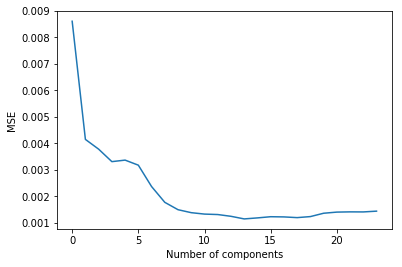

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(mse_n_comps)
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.show()

In [8]:
n_comp = np.array(mse_n_comps).argmin() + 1
n_comp

14

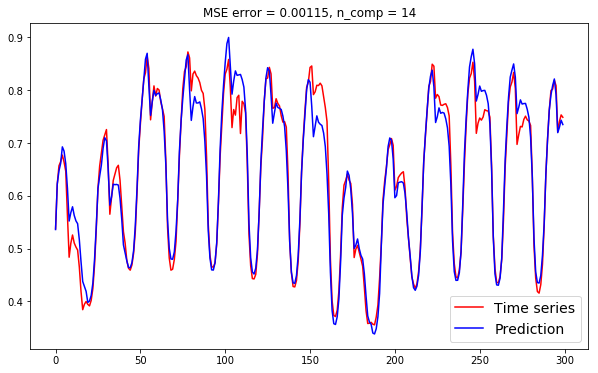

In [9]:
pls = PLSLinear(n_components=n_comp)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

ts_test = Y_test.ravel()
ts_pred = Y_pred.ravel()

plt.figure(figsize=(10, 6))
plt.plot(ts_test[:300], label='Time series', c='r')
plt.plot(ts_pred[:300], label='Prediction', c='b')
plt.title('MSE error = {:.5f}, n_comp = {}'.format(mean_squared_error(Y_test, Y_pred), n_comp))
plt.legend(fontsize=14)
plt.show()

### Nonlinear transformations

In [47]:
def g1(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x)) - 1)


def g2(x, a=0.):
    return np.sign(x) * np.exp(a) * np.sqrt(np.abs(x))


def g3(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.sqrt(np.abs(x))) - 1)


def g4(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x) ** (1./3)) - 1)

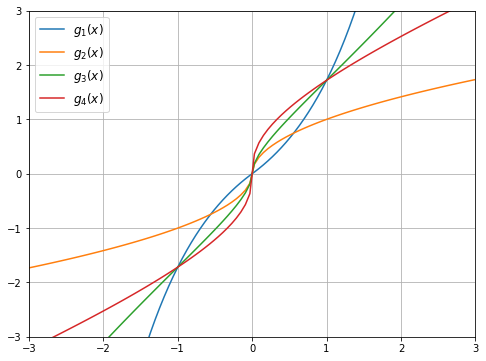

In [51]:
funcs_names = ['$g_1(x)$', '$g_2(x)$', '$g_3(x)$', '$g_4(x)$']
funcs = [g1, g2, g3, g4]
x = np.linspace(start=-3, stop=3, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(x, f(x), label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-3., 3.])
plt.ylim([-3., 3.])
plt.show()

In [52]:
def ginv_1(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)


def ginv_2(y, a=0.):
    return np.sign(y) * (np.exp(-a) * y) ** 2


def ginv_3(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 2


def ginv_4(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 3

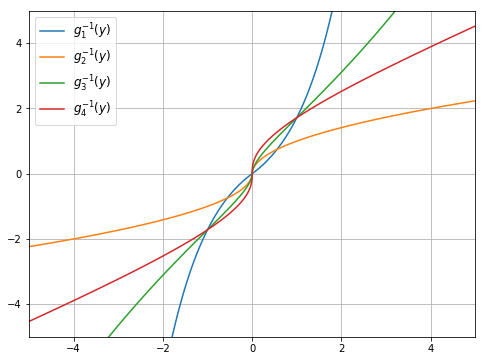

In [53]:
funcs_names = ['$g^{-1}_1(y)$', '$g^{-1}_2(y)$', '$g^{-1}_3(y)$', '$g^{-1}_4(y)$']
funcs = [ginv_1, ginv_2, ginv_3, ginv_4]
x = np.linspace(start=-5, stop=5, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(f(x), x, label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-5., 5.])
plt.ylim([-5., 5.])
plt.show()

In [54]:
a = np.array([[1., 2.], [3., 4.]])
b = np.zeros_like(a)

array([[ 1.,  2.],
       [ 3.,  4.]])